In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from sklearn.utils.class_weight import compute_class_weight

In [33]:
# Load the dataset (replace with your actual CSV or DataFrame)
df = pd.read_csv('diabetic_data_clean.csv')  # Replace with actual file path or DataFrame

In [34]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,15738,63555939,Caucasian,Female,10,3,3,4,12,InternalMedicine,...,No,2,No,No,No,No,No,Ch,Yes,NO
1,40926,85504905,Caucasian,Female,5,1,3,7,7,Family/GeneralPractice,...,No,1,No,No,No,No,No,Ch,Yes,<30
2,42570,77586282,Caucasian,Male,9,1,6,7,10,Family/GeneralPractice,...,No,2,No,No,No,No,No,No,Yes,NO
3,84222,108662661,Caucasian,Female,6,1,1,7,3,Cardiology,...,No,0,No,No,No,No,No,No,Yes,NO
4,236316,40523301,Caucasian,Male,9,1,3,7,6,Cardiology,...,No,0,No,No,No,No,No,Ch,Yes,NO


In [35]:
# Handle Missing Values
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [36]:
# Encode Categorical Columns (Label Encoding)
categorical_columns = df_imputed.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for column in categorical_columns:
    df_imputed[column] = label_encoder.fit_transform(df_imputed[column])

In [37]:
# Separate Features (X) and Target (y)
X = df_imputed.drop('insulin', axis=1).values  # Features
y = df_imputed['insulin'].values  # Target Variable

In [38]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Get the unique classes in y_train
unique_classes = np.unique(y_train)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [40]:
# Define the TabNet model
clf = TabNetClassifier(
    n_d=32,  # number of decision steps
    n_a=32,  # attention width
    n_steps=3,  # number of steps
    gamma=1.5,  # scaling factor for features
    n_independent=2,  # number of independent layers
    n_shared=2,  # number of shared layers
    lambda_sparse=1e-5,  # sparsity regularization
    optimizer_fn=torch.optim.Adam,  # optimizer function
    optimizer_params=dict(lr=1e-2),  # learning rate inside optimizer params
    scheduler_fn=torch.optim.lr_scheduler.StepLR,  # learning rate scheduler
    scheduler_params=dict(step_size=10, gamma=0.9),  # scheduler parameters
)

C:\Users\Sanjo George\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [41]:
# Use custom loss function with class weights if needed
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Train the model with early stopping
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,  # maximum number of epochs
    patience=20,  # early stopping patience
    batch_size=256,  # batch size
    virtual_batch_size=128,  # virtual batch size
    num_workers=0,  # number of workers for data loading
    loss_fn=loss_fn  # pass the custom loss function
)

epoch 0  | loss: 1.07479 | test_accuracy: 0.61502 |  0:00:06s
epoch 1  | loss: 0.80704 | test_accuracy: 0.70056 |  0:00:13s
epoch 2  | loss: 0.69957 | test_accuracy: 0.73224 |  0:00:19s
epoch 3  | loss: 0.67896 | test_accuracy: 0.75003 |  0:00:25s
epoch 4  | loss: 0.66646 | test_accuracy: 0.72785 |  0:00:31s
epoch 5  | loss: 0.66006 | test_accuracy: 0.74113 |  0:00:37s
epoch 6  | loss: 0.65597 | test_accuracy: 0.73633 |  0:00:43s
epoch 7  | loss: 0.65666 | test_accuracy: 0.74062 |  0:00:49s
epoch 8  | loss: 0.64853 | test_accuracy: 0.75095 |  0:00:55s
epoch 9  | loss: 0.64523 | test_accuracy: 0.75248 |  0:01:01s
epoch 10 | loss: 0.64199 | test_accuracy: 0.76403 |  0:01:07s
epoch 11 | loss: 0.64078 | test_accuracy: 0.73408 |  0:01:13s
epoch 12 | loss: 0.63661 | test_accuracy: 0.75258 |  0:01:19s
epoch 13 | loss: 0.63687 | test_accuracy: 0.74768 |  0:01:25s
epoch 14 | loss: 0.63905 | test_accuracy: 0.75146 |  0:01:31s
epoch 15 | loss: 0.63555 | test_accuracy: 0.74941 |  0:01:37s
epoch 16

C:\Users\Sanjo George\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [42]:
# Model Evaluation
y_pred = clf.predict(X_test)

In [48]:
# Compute Test Accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Compute Evaluation Accuracy (based on model evaluation set)
eval_accuracy = accuracy_score(y_test, clf.predict(X_test)) * 100
print(f"Evaluation Accuracy: {eval_accuracy:.2f}%")

Test Accuracy: 76.40%
Evaluation Accuracy: 76.40%


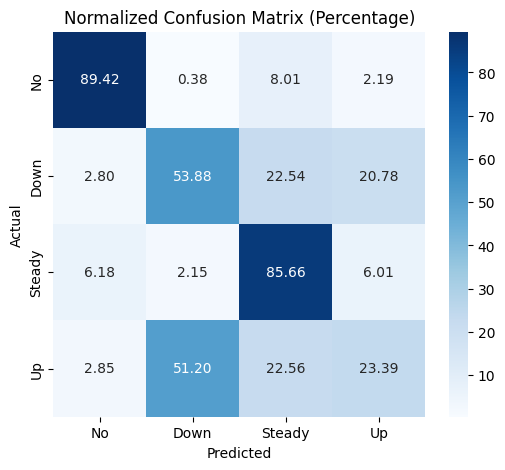

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      4471
           1       0.51      0.54      0.53      1251
           2       0.74      0.86      0.80      2977
           3       0.32      0.23      0.27      1086

    accuracy                           0.76      9785
   macro avg       0.63      0.63      0.63      9785
weighted avg       0.76      0.76      0.76      9785

ROC-AUC Score (Macro Average): 0.9377


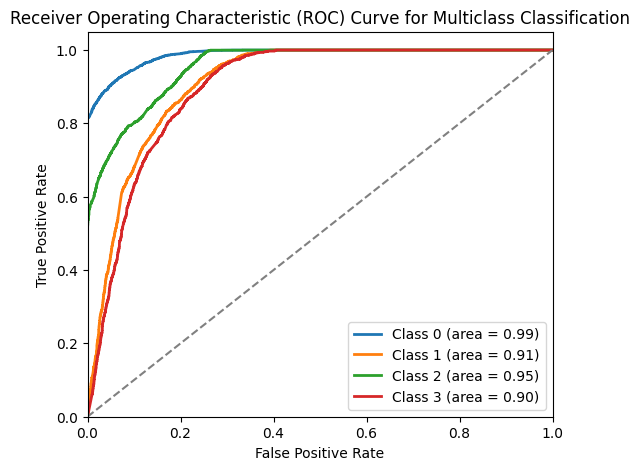

In [52]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

# Confusion Matrix (normalized to show percentages)
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by dividing by the sum of each row
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Get the class labels (unique values from the target variable)
class_labels = ["No", "Down", "Steady", "Up"]  # Using np.unique for NumPy arrays

# Plot the Confusion Matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Multiclass ROC-AUC Score
# Ensure that the classes in label_binarize match the unique labels in y_test
classes = np.unique(y_test)  # Get unique classes from the true labels
y_test_bin = label_binarize(y_test, classes=classes)  # Correct the binarization based on actual classes
y_pred_prob = clf.predict_proba(X_test)

# Check the number of classes in y_pred_prob to make sure it matches y_test_bin
n_classes = y_test_bin.shape[1]
assert y_pred_prob.shape[1] == n_classes, f"Mismatch in number of classes: {y_pred_prob.shape[1]} vs {n_classes}"

# Compute ROC AUC score (macro average for multiclass)
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr')
print(f"ROC-AUC Score (Macro Average): {roc_auc:.4f}")

# Plot ROC Curves for each class
plt.figure(figsize=(6, 5))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i]):.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()
